In [1]:
import numpy as np 
import torch
import cv2

In [2]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt

In [3]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [4]:
#You may need this to access the datasets. 
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
#This is the training data. 
from torchvision.datasets import CIFAR10
train_data = datasets.CIFAR10(root="train/",
train=True,
download=True,
transform = ToTensor())

Files already downloaded and verified


In [6]:
#Test data. 
test_data = datasets.CIFAR10(root="test/",
train=False,
download=True,
transform = ToTensor())

Files already downloaded and verified


In [7]:
print(train_data)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: train/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [8]:
print(test_data)

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: test/
    Split: Test
    StandardTransform
Transform: ToTensor()


In [9]:
dir(train_data)

['__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_integrity',
 '_format_transform_repr',
 '_is_protocol',
 '_load_meta',
 '_repr_indent',
 'base_folder',
 'class_to_idx',
 'classes',
 'data',
 'download',
 'extra_repr',
 'filename',
 'meta',
 'root',
 'target_transform',
 'targets',
 'test_list',
 'tgz_md5',
 'train',
 'train_list',
 'transform',
 'transforms',
 'url']

In [10]:
train_data.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [11]:
test_data.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [12]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break


Shape of X [N, C, H, W]: torch.Size([64, 3, 32, 32])
Shape of y: torch.Size([64]) torch.int64


In [13]:
def label_array(dataloader):
    # initialize the empty list
    cifar10_test_labels = []
    
    # read data from dataloader
    for inputs, labels in dataloader:
        # add labels to list cifar10_test_labels
        cifar10_test_labels.append(labels)
    
    # convert cifar10_test_labels to tensor
    cifar10_test_labels = torch.cat(cifar10_test_labels,dim=0) 
    
    return cifar10_test_labels

In [14]:
# check function label_array
label_array(test_dataloader)

tensor([3, 8, 8,  ..., 5, 1, 7])

In [15]:
label_array(test_dataloader).shape

torch.Size([10000])

In [16]:
class CIFARConvNet(nn.Module):
    def __init__(self):
        super(CIFARConvNet, self).__init__()
        #the convolution layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding='same'),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding='same'),
            nn.ReLU()
        )
        #the MaxPool layers
        self.pool = nn.MaxPool2d(kernel_size=2)
        nn.Dropout(0.25)
        
        #the standard layers
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4096, 256),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256,10)
        )
       
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [148]:
# declare variable to store training history
train_his = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}
# split train_data into train_subset and validation_subset
train_subset, val_subset = torch.utils.data.random_split(
        train_data, [40000, 10000], generator=torch.Generator().manual_seed(1))

# create dataloader for train_subset and validation_subset
train_dataloader = DataLoader(train_subset, batch_size=batch_size)
val_dataloader = DataLoader(val_subset, batch_size=batch_size)

# calculate steps per epoch for training set
train_steps = len(train_dataloader.dataset) // batch_size
val_steps = len(val_dataloader.dataset) // batch_size

In [159]:
import time
lr = 1e-3
num_epochs = 60
# initialize model
model = CIFARConvNet().to(device)
# select loss function
loss_fn = nn.CrossEntropyLoss()
# select optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# measure how long training is going to take
print("[INFO] training the network...")
startTime = time.time()

for epochs in range(num_epochs):
    # set the model in training mode
    model.train()
    # initialize the total training and validation loss
    total_train_loss = 0
    total_val_loss = 0
    # initialize the number of correct predictions in the training step
    train_accuracy = 0
    val_accuracy = 0
    # loop over the training set
    for (x, y) in train_dataloader:
        # send the input to the device
        (x, y) = (x.to(device), y.to(device))
        # perform a forward pass and calculate the training loss
        pred = model(x)
        loss = loss_fn(pred, y)
        # zero out the gradients, perform the backpropagation step, and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # add the loss to the total training loss so far and calculate the number of correct predictions
        total_train_loss += loss
        train_accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
     
    # switch off autograd for evaluation
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        # loop over the validation set
        for (x, y) in val_dataloader:
            # send the input to the device
            (x, y) = (x.to(device), y.to(device))
            # make the predictions and calculate the validation loss
            pred = model(x)
            total_val_loss += loss_fn(pred, y)
            # calculate the number of correct predictions
            val_accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    # calculate the average training loss and validation loss
    avg_train_loss = total_train_loss / train_steps
    avg_val_loss = total_val_loss / val_steps

    # calculate the training accuracy
    train_accuracy = train_accuracy / len(train_dataloader.dataset)
    val_accuracy = val_accuracy / len(val_dataloader.dataset)
    
    # update our training history
    train_his["train_loss"].append(avg_train_loss.cpu().detach().numpy())
    train_his["train_acc"].append(train_accuracy)
    train_his["val_loss"].append(avg_val_loss.cpu().detach().numpy())
    train_his["val_acc"].append(val_accuracy)
    
    # print the model training information
    print("    EPOCH: {}/{}".format(epochs + 1, num_epochs))
    print("       Train loss: {:.6f}, Train accuracy: {:.4f}".format(avg_train_loss, train_accuracy))
    print("       Validation loss: {:.6f}, Validation accuracy: {:.4f}".format(avg_val_loss, val_accuracy))
    
        
# finish measuring how long training took
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...
    EPOCH: 1/60
       Train loss: 1.585631, Train accuracy: 0.4235
       Validation loss: 1.295445, Validation accuracy: 0.5347
    EPOCH: 2/60
       Train loss: 1.240099, Train accuracy: 0.5583
       Validation loss: 1.102593, Validation accuracy: 0.6119
    EPOCH: 3/60
       Train loss: 1.081914, Train accuracy: 0.6166
       Validation loss: 1.014575, Validation accuracy: 0.6363
    EPOCH: 4/60
       Train loss: 0.984198, Train accuracy: 0.6538
       Validation loss: 1.001759, Validation accuracy: 0.6458
    EPOCH: 5/60
       Train loss: 0.903931, Train accuracy: 0.6805
       Validation loss: 0.959133, Validation accuracy: 0.6648
    EPOCH: 6/60
       Train loss: 0.841330, Train accuracy: 0.7029
       Validation loss: 0.952182, Validation accuracy: 0.6652
    EPOCH: 7/60
       Train loss: 0.786465, Train accuracy: 0.7238
       Validation loss: 0.898338, Validation accuracy: 0.6879
    EPOCH: 8/60
       Train loss: 0.724433, Train accuracy

In [158]:
# this variable store the result of training with 400+ epochs
len(train_his_400plus["val_acc"])

446

In [142]:
# function for plotting the loss and accuracy
def plot_train_loss(loss_dict, txt):
    # create data for y-axis
    y1=np.array(loss_dict["train_loss"])
    y2=np.array(loss_dict["train_acc"])
    y3=np.array(loss_dict["val_loss"])
    y4=np.array(loss_dict["val_acc"])
    # create data for x-axis
    X = np.linspace(1, len(y1), num=len(y1)).reshape(-1,1)
    # plotting
    plt.xlabel('# of epochs')
    plt.plot(X, y1, 'b-')
    plt.plot(X, y2, 'b--')
    plt.plot(X, y3, 'r-')
    plt.plot(X, y4, 'r--')
    plt.legend(['train loss','train accuracy','validation loss','validation accuracy'],fontsize='small')
    plt.title(txt, fontsize=10)

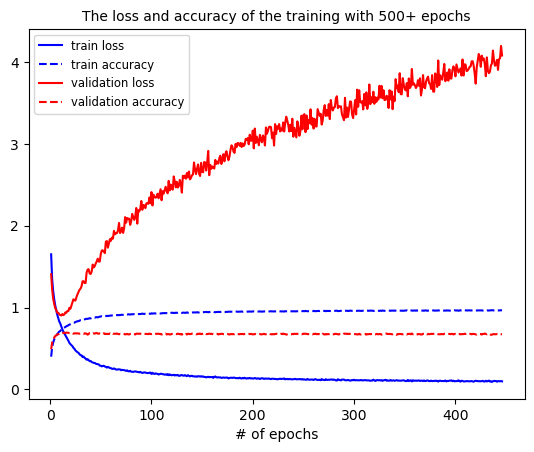

In [157]:
plot_train_loss(train_his_400plus, "The loss and accuracy of the training with 500+ epochs")

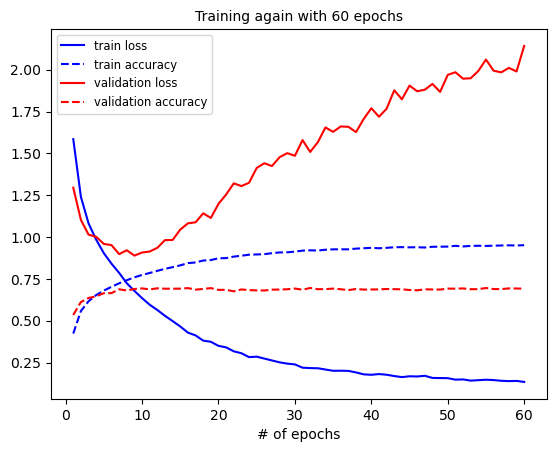

In [160]:
plot_train_loss(train_his, "Training again with 60 epochs")

In [161]:
# save trained model to local directory
torch.save(model.state_dict(), "cifar_convnet1")

In [162]:
# load the model
model1 = CIFARConvNet().to(device)
model1.load_state_dict(torch.load("cifar_convnet1", weights_only=True))

<All keys matched successfully>

In [163]:
def get_prediction(dataloader, model):
    pred = []
    # set model to prediction state
    model.eval()
    # loop through the dataloader
    for inputs, labels in dataloader:
        with torch.no_grad():
            # send the input to the device
            inputs = inputs.to(device)
            # make the predictions 
            outputs = model(inputs)
            # identify the predicted class
            predict = outputs.max(dim=1)
            # add them to the list
            pred.append(predict.indices)
    
    # convert list to tensor
    pred = torch.cat(pred,dim=0)
    return pred

In [164]:
def calculate_accuracy(test_label, predicted):
    # calculate the accuracy
    acc = sum(test_label==predicted).item()/len(test_label)
    return acc

In [165]:
def confusion_dict(test_label, predicted):
    conf_dict = {}
    # convert tensor to numpy
    test_np = test_label.numpy()
    predicted_np = predicted.numpy()
    
    for key in range(10):
        # filter the incorrect prediction in predicted list
        error_label = predicted_np[(test_np==key) & (predicted_np!=key)]
        # calculate the frequency of each incorrect label
        unique, counts = np.unique(error_label, return_counts=True)
        # add the top 2 incorrect predictions into conf_dict
        if len(counts) < 2:
            conf_dict[key] = tuple(unique)
        else:
            conf_dict[key] = tuple(unique[np.argsort(counts)[len(counts)-2:]])
        
    return conf_dict

In [166]:
# predict
predicted = get_prediction(test_dataloader, model1)

In [167]:
# get test label
test_label = label_array(test_dataloader)

In [168]:
# accuracy
calculate_accuracy(test_label,predicted)

0.6897

In [169]:
# confusion dictionary
conf_dict = confusion_dict(test_label,predicted)
conf_dict

{0: (2, 8),
 1: (8, 9),
 2: (4, 5),
 3: (6, 5),
 4: (2, 7),
 5: (2, 3),
 6: (2, 3),
 7: (4, 5),
 8: (1, 0),
 9: (0, 1)}

In [170]:
# function for giving comments based on the confusion dictionary
def comment(conf_dict):
    # get class based on index
    def get_class(index):
        return list(test_data.class_to_idx.keys())[list(test_data.class_to_idx.values()).index(index)]
    
    # plot first incorrect prediction
    def plot_top_diff(test_label, predicted, txt, key1, key2, key3=-1):
        test_np = test_label.numpy()
        predicted_np = predicted.numpy()
        # get index of images with label key1
        key1_idx = np.argwhere(test_np==key1)
        # filter prediction of image with label key1
        key1_predict = predicted_np[test_np==key1]
        # get index of prediction: key1 to key2
        key2_idx = np.argwhere(key1_predict==key2)
        # plot first incorrect predicted image: key1 to key2
        plt.figure(figsize=(5, 2))
        plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=12, fontstyle="italic")
        plt.subplot(121); plt.imshow(test_data.data[key1_idx[key2_idx[0][0]][0]]); plt.axis('off');
        plt.title("{} >> {}".format(get_class(key1),get_class(key2)), fontsize=10);
        if key3 > -1:
            # get index of prediction: key1 to key3
            key3_idx = np.argwhere(key1_predict==key3)
            # plot first incorrect predicted image: key1 to key3
            plt.subplot(122); plt.imshow(test_data.data[key1_idx[key3_idx[0][0]][0]]); plt.axis('off');
            plt.title("{} >> {}".format(get_class(key1),get_class(key3)), fontsize=10);
            
    # print comment
    for key in conf_dict.keys():
        no_of_err = 1 if type(conf_dict[key]) is int else len(conf_dict[key])
        if no_of_err==0:
            print("{} are classified properly.\n".format(get_class(key)))
        elif no_of_err==1:
            err = 0 if type(conf_dict[key]) is int else conf_dict[key][0]
            txt = "{} are confused with {}.\n".format(get_class(key),
                                                      get_class(err))
            plot_top_diff(test_label, predicted, txt, key, err)
        else:
            txt = "{} are confused with {} and {}.\n".format(get_class(key),
                                                             get_class(conf_dict[key][0]),
                                                             get_class(conf_dict[key][1]))
            plot_top_diff(test_label, predicted, txt, key, conf_dict[key][0], conf_dict[key][1])

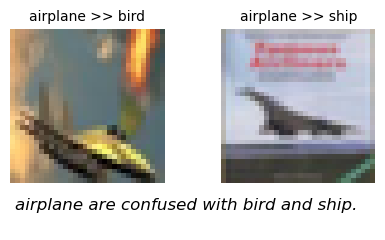

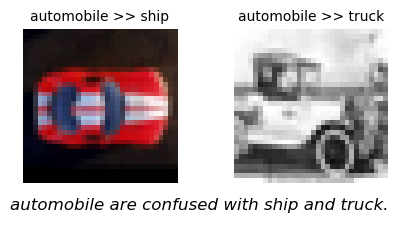

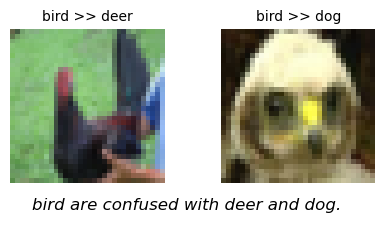

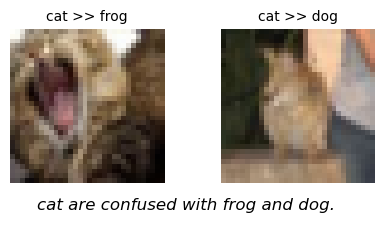

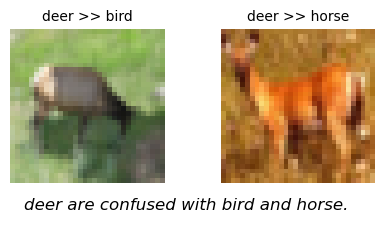

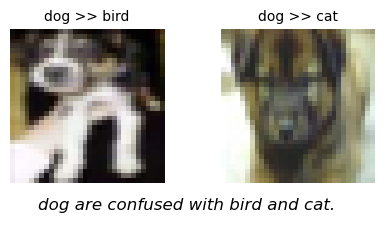

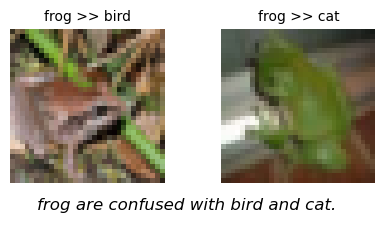

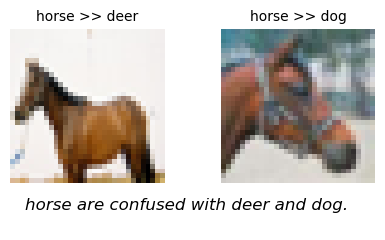

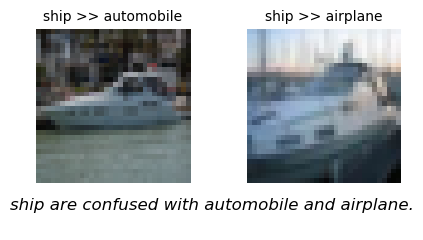

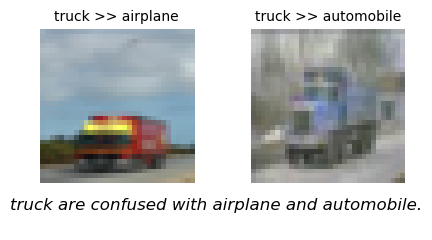

In [171]:
# comment on the errors
comment(conf_dict)